# [TITLE]

[URL]

<div class="alert">

The most important thing to work with this template notebook is that all the variables in uppercase (as for example "PATH") are the ones that you must change based on the dataset you are working with.

</div>

## Load data

In [1]:
# PATH = "../../../data/EIA/fuel_type_data_california.parquet"
PATH = "../../../data/EIA/energy_by_fueltype_ciso.csv"


In [76]:
import pandas as pd
# df = pd.read_parquet(PATH)
df = pd.read_csv(PATH)

df


,period,respondent,respondent-name,fueltype,type-name,value,value-units
0,2025-08-03 23:00:00-07:00,CISO,California Independent System Operator,COL,Coal,0.0,megawatthours
1,2025-08-03 23:00:00-07:00,CISO,California Independent System Operator,NG,Natural Gas,7925.0,megawatthours
...,...,...,...,...,...,...,...
446164,2018-12-31 16:00:00-08:00,CISO,California Independent System Operator,WAT,Hydro,2403.0,megawatthours
446165,2018-12-31 16:00:00-08:00,CISO,California Independent System Operator,WND,Wind,2497.0,megawatthours


## Preprocess data

### Datetime column object

In [77]:
COLUMN_DATETIME = "period"

x = pd.to_datetime(df[COLUMN_DATETIME], utc=True)
x


0        2025-08-04 06:00:00+00:00
1        2025-08-04 06:00:00+00:00
                    ...           
446164   2019-01-01 00:00:00+00:00
446165   2019-01-01 00:00:00+00:00
Name: period, Length: 446166, dtype: datetime64[ns, UTC]

In [78]:
df[COLUMN_DATETIME] = x
df


,period,respondent,respondent-name,fueltype,type-name,value,value-units
0,2025-08-04 06:00:00+00:00,CISO,California Independent System Operator,COL,Coal,0.0,megawatthours
1,2025-08-04 06:00:00+00:00,CISO,California Independent System Operator,NG,Natural Gas,7925.0,megawatthours
...,...,...,...,...,...,...,...
446164,2019-01-01 00:00:00+00:00,CISO,California Independent System Operator,WAT,Hydro,2403.0,megawatthours
446165,2019-01-01 00:00:00+00:00,CISO,California Independent System Operator,WND,Wind,2497.0,megawatthours


### Local timezones

In [79]:
TIMEZONE = "America/Los_Angeles"

x = df[COLUMN_DATETIME]

try:
    x = x.dt.tz_convert(TIMEZONE).dt.tz_localize(None).astype("datetime64[ns]")
except Exception as e:
    print(e)

x


0        2025-08-03 23:00:00
1        2025-08-03 23:00:00
                 ...        
446164   2018-12-31 16:00:00
446165   2018-12-31 16:00:00
Name: period, Length: 446166, dtype: datetime64[ns]

In [80]:
df[COLUMN_DATETIME] = x
df


,period,respondent,respondent-name,fueltype,type-name,value,value-units
0,2025-08-03 23:00:00,CISO,California Independent System Operator,COL,Coal,0.0,megawatthours
1,2025-08-03 23:00:00,CISO,California Independent System Operator,NG,Natural Gas,7925.0,megawatthours
...,...,...,...,...,...,...,...
446164,2018-12-31 16:00:00,CISO,California Independent System Operator,WAT,Hydro,2403.0,megawatthours
446165,2018-12-31 16:00:00,CISO,California Independent System Operator,WND,Wind,2497.0,megawatthours


### Available series inside dataset

In [81]:
# Esta celda devuelve como resultado todas las combinaciones posibles de las columnas categóricas del DataFrame, en base a las cuales vamos a armar el index del DataFrame:

COLUMN_CATEGORIES = ['respondent', 'respondent-name', 'fueltype', 'type-name']

df[COLUMN_CATEGORIES].drop_duplicates().style


,respondent,respondent-name,fueltype,type-name
0,CISO,California Independent System Operator,COL,Coal
1,CISO,California Independent System Operator,NG,Natural Gas
2,CISO,California Independent System Operator,NUC,Nuclear
3,CISO,California Independent System Operator,OIL,Petroleum
4,CISO,California Independent System Operator,OTH,Other
5,CISO,California Independent System Operator,SUN,Solar
6,CISO,California Independent System Operator,WAT,Hydro
7,CISO,California Independent System Operator,WND,Wind


### Set index

The index is composed by the columns that uniquely identify the rows. The datetime column must be present.

In [82]:
COLUMN_CATEGORIES = ['respondent-name', 'type-name']

idx = COLUMN_CATEGORIES + [COLUMN_DATETIME]
idx


['respondent-name', 'type-name', 'period']

In [83]:
COLUMN_CATEGORIES = ['respondent-name', 'type-name']

idx = COLUMN_CATEGORIES + [COLUMN_DATETIME]
x = df.set_index(idx).sort_index()

x


respondent  \
respondent-name                        type-name period                           
California Independent System Operator Coal      2018-12-31 16:00:00       CISO   
                                                 2018-12-31 17:00:00       CISO   
...                                                                         ...   
                                       Wind      2025-08-03 22:00:00       CISO   
                                                 2025-08-03 23:00:00       CISO   

                                                                     fueltype  \
respondent-name                        type-name period                         
California Independent System Operator Coal      2018-12-31 16:00:00      COL   
                                                 2018-12-31 17:00:00      COL   
...                                                                       ...   
                                       Wind      2025-08-03 22:00:00      WND   
                                                 2025-08-03 23:00:00      WND   

                                                                       value  \
respondent-name                        type-name period                        
California Independent System Operator Coal      2018-12-31 16:00:00     9.0   
                                                 2018-12-31 17:00:00    11.0   
...                                                                      ...   
                                       Wind      2025-08-03 22:00:00  4851.0   
                                                 2025-08-03 23:00:00  4898.0   

                                                                        value-units  
respondent-name                        type-name period                              
California Independent System Operator Coal      2018-12-31 16:00:00  megawatthours  
                                                 2018-12-31 17:00:00  megawatthours  
...                                                                             ...  
                                       Wind      2025-08-03 22:00:00  megawatthours  
                                                 2025-08-03 23:00:00  megawatthours  

[446166 rows x 4 columns]

In [84]:
# Para que todo esté ok, esto debería devolver un True, que significa que el index no presenta valores duplicados...

x.index.is_unique


False

In [85]:
# Rastreando los index duplicados...

x.index.to_series()


respondent-name                         type-name  period             
California Independent System Operator  Coal       2018-12-31 16:00:00    (California Independent System Operator, Coal,...
                                                   2018-12-31 17:00:00    (California Independent System Operator, Coal,...
                                                                                                ...                        
                                        Wind       2025-08-03 22:00:00    (California Independent System Operator, Wind,...
                                                   2025-08-03 23:00:00    (California Independent System Operator, Wind,...
Length: 446166, dtype: object

In [86]:
# Para ver cuáles son los index duplicados...

# x.index.duplicated(keep=False)
# x[x.index.duplicated(keep=False)].style
x[x.index.duplicated(keep=False)]


respondent  \
respondent-name                        type-name period                           
California Independent System Operator Coal      2019-11-03 01:00:00       CISO   
                                                 2019-11-03 01:00:00       CISO   
...                                                                         ...   
                                       Wind      2024-11-03 01:00:00       CISO   
                                                 2024-11-03 01:00:00       CISO   

                                                                     fueltype  \
respondent-name                        type-name period                         
California Independent System Operator Coal      2019-11-03 01:00:00      COL   
                                                 2019-11-03 01:00:00      COL   
...                                                                       ...   
                                       Wind      2024-11-03 01:00:00      WND   
                                                 2024-11-03 01:00:00      WND   

                                                                       value  \
respondent-name                        type-name period                        
California Independent System Operator Coal      2019-11-03 01:00:00    13.0   
                                                 2019-11-03 01:00:00    13.0   
...                                                                      ...   
                                       Wind      2024-11-03 01:00:00  3321.0   
                                                 2024-11-03 01:00:00  3223.0   

                                                                        value-units  
respondent-name                        type-name period                              
California Independent System Operator Coal      2019-11-03 01:00:00  megawatthours  
                                                 2019-11-03 01:00:00  megawatthours  
...                                                                             ...  
                                       Wind      2024-11-03 01:00:00  megawatthours  
                                                 2024-11-03 01:00:00  megawatthours  

[92 rows x 4 columns]

In [87]:
# Si quitara los duplicados del index, sí me devuelve el True...

x.index.drop_duplicates().is_unique


True

<div class="alert alert-block alert-info">
En este caso voy a simplemente eliminar las filas duplicadas, aunque ojo porque no es una mejor práctica... Idealmente debería ver por qué hay valores duplicados y resolver qué hacer (por ejemplo, agregarlos en la manera que corresponda, como por ejemplo sumando o promediando los valores)
</div>

In [88]:
# En este caso voy a simplemente eliminar las filas duplicadas, aunque ojo porque no es una mejor práctica... Idealmente debería ver por qué hay valores duplicados y resolver qué hacer (por ejemplo, agregarlos en la manera que corresponda, como por ejemplo sumando o promediando los valores)

duplicated_indices = x.index.duplicated(keep='first')       # es una "mask"
x = x[~duplicated_indices]
x


respondent  \
respondent-name                        type-name period                           
California Independent System Operator Coal      2018-12-31 16:00:00       CISO   
                                                 2018-12-31 17:00:00       CISO   
...                                                                         ...   
                                       Wind      2025-08-03 22:00:00       CISO   
                                                 2025-08-03 23:00:00       CISO   

                                                                     fueltype  \
respondent-name                        type-name period                         
California Independent System Operator Coal      2018-12-31 16:00:00      COL   
                                                 2018-12-31 17:00:00      COL   
...                                                                       ...   
                                       Wind      2025-08-03 22:00:00      WND   
                                                 2025-08-03 23:00:00      WND   

                                                                       value  \
respondent-name                        type-name period                        
California Independent System Operator Coal      2018-12-31 16:00:00     9.0   
                                                 2018-12-31 17:00:00    11.0   
...                                                                      ...   
                                       Wind      2025-08-03 22:00:00  4851.0   
                                                 2025-08-03 23:00:00  4898.0   

                                                                        value-units  
respondent-name                        type-name period                              
California Independent System Operator Coal      2018-12-31 16:00:00  megawatthours  
                                                 2018-12-31 17:00:00  megawatthours  
...                                                                             ...  
                                       Wind      2025-08-03 22:00:00  megawatthours  
                                                 2025-08-03 23:00:00  megawatthours  

[446120 rows x 4 columns]

In [89]:
df = x.copy()


In [90]:
df


respondent  \
respondent-name                        type-name period                           
California Independent System Operator Coal      2018-12-31 16:00:00       CISO   
                                                 2018-12-31 17:00:00       CISO   
...                                                                         ...   
                                       Wind      2025-08-03 22:00:00       CISO   
                                                 2025-08-03 23:00:00       CISO   

                                                                     fueltype  \
respondent-name                        type-name period                         
California Independent System Operator Coal      2018-12-31 16:00:00      COL   
                                                 2018-12-31 17:00:00      COL   
...                                                                       ...   
                                       Wind      2025-08-03 22:00:00      WND   
                                                 2025-08-03 23:00:00      WND   

                                                                       value  \
respondent-name                        type-name period                        
California Independent System Operator Coal      2018-12-31 16:00:00     9.0   
                                                 2018-12-31 17:00:00    11.0   
...                                                                      ...   
                                       Wind      2025-08-03 22:00:00  4851.0   
                                                 2025-08-03 23:00:00  4898.0   

                                                                        value-units  
respondent-name                        type-name period                              
California Independent System Operator Coal      2018-12-31 16:00:00  megawatthours  
                                                 2018-12-31 17:00:00  megawatthours  
...                                                                             ...  
                                       Wind      2025-08-03 22:00:00  megawatthours  
                                                 2025-08-03 23:00:00  megawatthours  

[446120 rows x 4 columns]

### Select values column

In [91]:
COLUMN_VALUES = "value"

x = df[COLUMN_VALUES]
x


respondent-name                         type-name  period             
California Independent System Operator  Coal       2018-12-31 16:00:00       9.0
                                                   2018-12-31 17:00:00      11.0
                                                                           ...  
                                        Wind       2025-08-03 22:00:00    4851.0
                                                   2025-08-03 23:00:00    4898.0
Name: value, Length: 446120, dtype: float64

In [92]:
x.unstack(level=COLUMN_CATEGORIES)


respondent-name     California Independent System Operator          \
type-name                                             Coal   Hydro   
period                                                               
2018-12-31 16:00:00                                    9.0  2403.0   
2018-12-31 17:00:00                                   11.0  3328.0   
...                                                    ...     ...   
2025-08-03 22:00:00                                    0.0  4170.0   
2025-08-03 23:00:00                                    0.0  4122.0   

respondent-name                                                            
type-name           Natural Gas Nuclear   Other Petroleum   Solar    Wind  
period                                                                     
2018-12-31 16:00:00      6574.0  2273.0   -22.0      88.0  1222.0  2497.0  
2018-12-31 17:00:00      9094.0  2274.0   -16.0      87.0   -30.0  2187.0  
...                         ...     ...     ...       ...     ...     ...  
2025-08-03 22:00:00      8377.0  2276.0  9317.0      46.0   -42.0  4851.0  
2025-08-03 23:00:00      7925.0  2276.0  7782.0      46.0   -33.0  4898.0  

[57745 rows x 8 columns]

In [93]:
pd.options.plotting.backend = 'matplotlib'
pd.options.plotting.backend


'matplotlib'

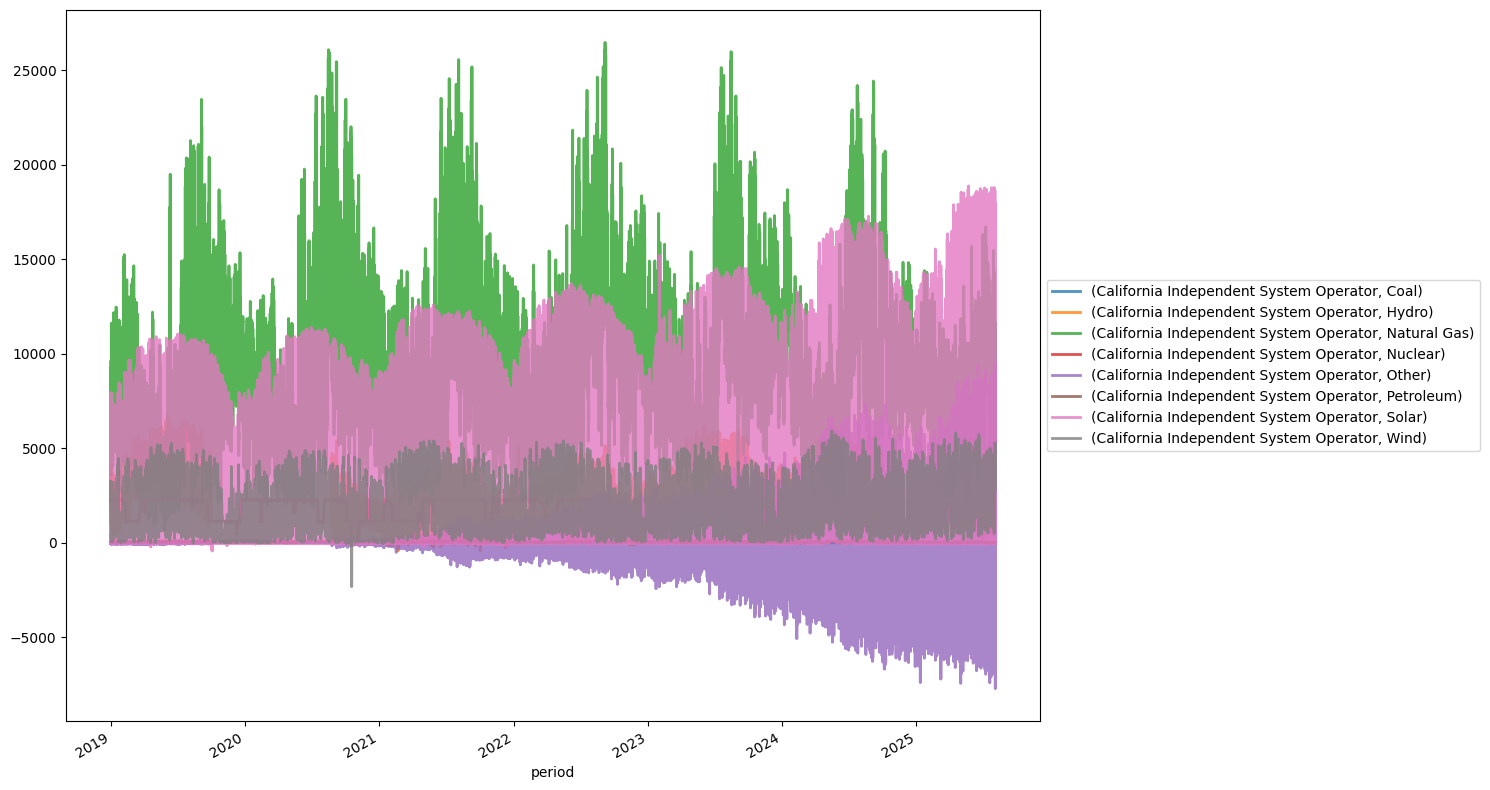

In [94]:
plot = x.unstack(level=COLUMN_CATEGORIES).plot(figsize=(15, 8), linewidth=2, alpha=0.8)
plot.legend(loc="center left", bbox_to_anchor=(1, 0.5))
plot.figure.tight_layout()


In [95]:
series = x.copy()


### Filter one time series

To get a table with the unique datetime index of the series, and the time series values.

<div class="alert alert-warning">
Not necessary if the data already represents a time series with unique datetime values.
</div>


In [96]:
CATEGORIES = ('California Independent System Operator', 'Solar')

x = series.loc[CATEGORIES]
x


period
2018-12-31 16:00:00    1222.0
2018-12-31 17:00:00     -30.0
                        ...  
2025-08-03 22:00:00     -42.0
2025-08-03 23:00:00     -33.0
Name: value, Length: 57739, dtype: float64

In [97]:
# Paso para configurar plotly_dark como api de plotting por defecto (en este caso hecho a través de una función definida en otro notebook del repositorio: carpeta "modules" - file "utils.py")

from modules import utils
utils.configure_plotly_template(showlegend=True)


In [98]:
x.plot()


In [99]:
series = x.copy()


### Filter datetime range

<div class="alert alert-warning">
Not necessary if you are interested in the whole time series. Although, it's advised to filter out outliers and incomplete data to get full periods, like full years, months, etc.
<br><br>
Además es importante quedarse con años completos! Por eso dejo fuera los que están todavía parciales al momento del ejercicio (hecho a mediados de 2025)
</div>

In [100]:
START, END = '2020', '2024'


In [101]:
x = series.loc[START:END]
x


period
2020-01-01 00:00:00   -31.0
2020-01-01 01:00:00   -31.0
                       ... 
2024-12-31 22:00:00   -51.0
2024-12-31 23:00:00   -51.0
Name: value, Length: 43817, dtype: float64

In [102]:
series = x.copy()


### Aggregate

**Check if you need to aggregate your data:**

- ✅ **Keep as-is** if data is already at appropriate frequency (monthly, quarterly, etc.)
- 🔄 **Aggregate first** if data is too granular for your seasonal question:
  - **Annual seasonality** → Aggregate to monthly
  - **Weekly patterns** → Aggregate to daily  
  - **Daily patterns** → Aggregate to hourly

**Rule of Thumb:**

Match your data frequency to the seasonal cycle you want to study. Most seasonal business analysis works best with **monthly data** to capture yearly patterns.

**Note**: You need at least 3-5 complete seasonal cycles for reliable decomposition results.

In [103]:
RULE = 'ME'     # ME: month end


In [108]:
x = series.resample(RULE).sum()
x.plot(kind='area')


In [109]:
series = x.copy()


## Individual component behaviour based on model

Components:

- Trend (T)
- Seasonality (S)
- Residual or Irregular Component (I)

Models:

- Additive model: $y_t = T_t + S_t + e_t$
- Multiplicative model: $y_t = T_t \times S_t \times e_t$

### Additive model

<div class="alert">
En este apartado sólo sería necesario modificar el PERIOD en función de los datos con que se cuenta para el análisis.
</div>

In [110]:
import statsmodels.api as sm


In [111]:
PERIOD = 12

result = sm.tsa.seasonal_decompose(series, model='additive', period=PERIOD)

x = (x
 .to_frame()
 .assign(
    trend = result.trend,
    seasonal = result.seasonal,
    residual = result.resid)
 .dropna())

x


,value,trend,seasonal,residual
period,,,,
2020-07-31,3519006.0,2.393224e+06,9.936955e+05,132086.551215
2020-08-31,2958575.0,2.411241e+06,6.627507e+05,-115416.313368
...,...,...,...,...
2024-05-31,4885282.0,3.701031e+06,9.305151e+05,253736.363715
2024-06-30,5175020.0,3.716327e+06,1.087185e+06,371508.394965


In [112]:
x['model_result'] = x.trend + x.seasonal + x.residual
x


,value,trend,seasonal,residual,model_result
period,,,,,
2020-07-31,3519006.0,2.393224e+06,9.936955e+05,132086.551215,3519006.0
2020-08-31,2958575.0,2.411241e+06,6.627507e+05,-115416.313368,2958575.0
...,...,...,...,...,...
2024-05-31,4885282.0,3.701031e+06,9.305151e+05,253736.363715,4885282.0
2024-06-30,5175020.0,3.716327e+06,1.087185e+06,371508.394965,5175020.0


In [113]:
dfs = {}
dfs['additive'] = x


### Multiplicative model

In [114]:
result = sm.tsa.seasonal_decompose(series, model='multiplicative', period=PERIOD)

x = (series
 .to_frame()
 .assign(
    trend = result.trend,
    seasonal = result.seasonal,
    residual = result.resid)
 .dropna())

x


,value,trend,seasonal,residual
period,,,,
2020-07-31,3519006.0,2.393224e+06,1.357825,1.082911
2020-08-31,2958575.0,2.411241e+06,1.234884,0.993609
...,...,...,...,...
2024-05-31,4885282.0,3.701031e+06,1.299406,1.015833
2024-06-30,5175020.0,3.716327e+06,1.344627,1.035610


In [115]:
x['model_result'] = x.trend * x.seasonal * x.residual
x


,value,trend,seasonal,residual,model_result
period,,,,,
2020-07-31,3519006.0,2.393224e+06,1.357825,1.082911,3519006.0
2020-08-31,2958575.0,2.411241e+06,1.234884,0.993609,2958575.0
...,...,...,...,...,...
2024-05-31,4885282.0,3.701031e+06,1.299406,1.015833,4885282.0
2024-06-30,5175020.0,3.716327e+06,1.344627,1.035610,5175020.0


In [116]:
dfs['multiplicative'] = x


## Model comparison

### Numerical

In [117]:
df = pd.concat(dfs, axis=1).melt(ignore_index=False).reset_index()
df.columns = ["month", "model", "component", "value"]


In [118]:
df


,month,model,component,value
0,2020-07-31,additive,value,3519006.0
1,2020-08-31,additive,value,2958575.0
...,...,...,...,...
478,2024-05-31,multiplicative,model_result,4885282.0
479,2024-06-30,multiplicative,model_result,5175020.0


## Visual comparison

In [119]:
import plotly.express as px

fig = px.line(
    data_frame=df,
    x='month',
    y='value',
    color='component',
    facet_col='model',
    facet_row='component',
    width=1500,
    height=1000,
    facet_col_spacing=0.1,
)

fig.update_yaxes(matches=None)

for attr in dir(fig.layout):
    if attr.startswith("yaxis"):
        axis = getattr(fig.layout, attr)
        if axis:
            axis.showticklabels = True
        
fig
